# Sail routing

In [1]:
import codecs
import datetime
import glob
import json

import ipywidgets as widgets
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from mpl_toolkits.basemap import Basemap
from pyproj import Geod, enums
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import differential_evolution

# Conversion between meters and nautical miles
NM = 1852.0

# A tiny value to prevent division by zero
EPS = 0.01

# A small value for speed "into the wind" an "on land"
SLOW = 0.01

# Geodetic system
geoid = Geod(ellps="WGS84")

## Set up start point, end point and the map

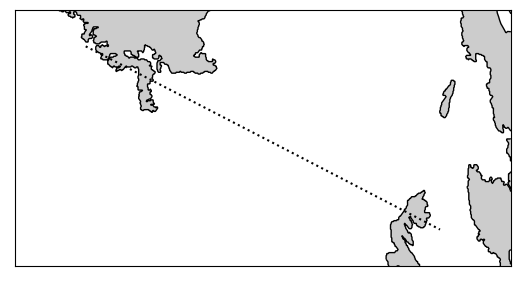

In [2]:
# Starting POSITION: Pula, Croatia
STA_LAT = 44.82634539483997
STA_LON = 13.832146078148572
START = np.array([[STA_LON], [STA_LAT]])

# END POSITION: Unije, Croatia
END_LAT = 44.65453596382963
END_LON = 14.299890952988706
END = np.array([[END_LON], [END_LAT]])

# Compute region of map
buffer = 0.2
MIN_LON = min(STA_LON, END_LON) - buffer * abs(STA_LON - END_LON)
MIN_LAT = min(STA_LAT, END_LAT) - buffer * abs(STA_LAT - END_LAT)
MAX_LON = max(STA_LON, END_LON) + buffer * abs(STA_LON - END_LON)
MAX_LAT = max(STA_LAT, END_LAT) + buffer * abs(STA_LAT - END_LAT)

# Create map
m = Basemap(
    llcrnrlon=MIN_LON,
    llcrnrlat=MIN_LAT,
    urcrnrlon=MAX_LON,
    urcrnrlat=MAX_LAT,
    resolution="f",
    projection="merc",
)

m.drawcoastlines()
m.fillcontinents()
m.drawgreatcircle(STA_LON, STA_LAT, END_LON, END_LAT, del_s=1, color="k", linestyle=":")
plt.show()

## Weather data

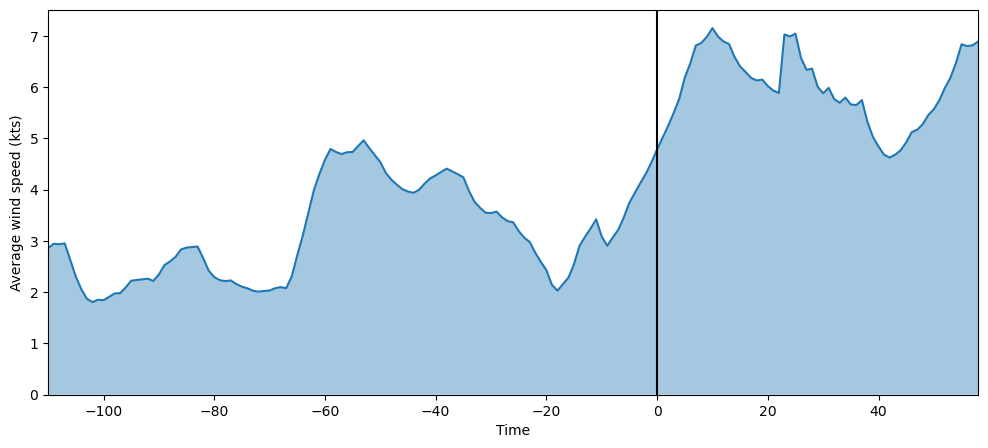

In [3]:
# Read GRIB file
files = glob.glob("weather/*.grb")
for file in files:
    ds = xr.open_dataset(file, engine="cfgrib")

# Build interpolation tables
start_time = 110
wind_time = (ds["step"] - ds["step"][0]).to_numpy().astype(
    float
) / 3600.0e9 - start_time
wind_lons = ds["longitude"].to_numpy()
wind_lats = ds["latitude"].to_numpy()
wind_u10 = ds["u10"].to_numpy()
wind_v10 = ds["v10"].to_numpy()
wind_u = RegularGridInterpolator(
    (wind_time, wind_lats, wind_lons), wind_u10, bounds_error=False, fill_value=0.0
)
wind_v = RegularGridInterpolator(
    (wind_time, wind_lats, wind_lons), wind_v10, bounds_error=False, fill_value=0.0
)

mean_wind = np.mean(np.sqrt(wind_u10**2 + wind_v10**2), axis=(1, 2))
plt.figure(figsize=(12, 5))
plt.plot(wind_time, mean_wind)
plt.fill_between(wind_time, 0, mean_wind, alpha=0.4)
plt.axvline(0.0, color="k")
plt.xlabel("Time")
plt.ylabel("Average wind speed (kts)")
plt.xlim([-start_time, wind_time[-1]])
plt.ylim(bottom=0)


# Wind function
def wind(time, lon, lat):
    t = time
    u = wind_u((t, lat, lon))
    v = wind_v((t, lat, lon))
    mag = np.sqrt(u**2 + v**2)
    dir = np.rad2deg(np.arctan(-v / (u + EPS))) - 90.0
    return [dir, mag]

## Load polar chart

In [4]:
# Load boats
boats = json.load(codecs.open("boats.json", "r", "utf-8-sig"), strict=False)
boat = list(filter(lambda b: b["boat"]["type"] == "Dufour 470", boats))[0]

# Align measured angles and wind speeds in a meshgrid for interpolation
min_angle = max(boat["vpp"]["beat_angle"])
max_angle = 180.0
a = np.array([min_angle] + boat["vpp"]["angles"] + [max_angle], dtype=float)
s = np.array(boat["vpp"]["speeds"], dtype=float)
angles, windspeeds = np.meshgrid(a, s)

# Fill table of velocities for interpolation
vel = np.zeros_like(angles)
vel[:, 0] = boat["vpp"]["beat_vmg"]
for i, angle in enumerate(boat["vpp"]["angles"]):
    vel[:, i + 1] = boat["vpp"][f"{angle}"]
vel[:, -1] = boat["vpp"]["run_vmg"]

# Build a look up table for interpolation of boat speed
lut = RegularGridInterpolator((s, a), vel, bounds_error=False, fill_value=SLOW)

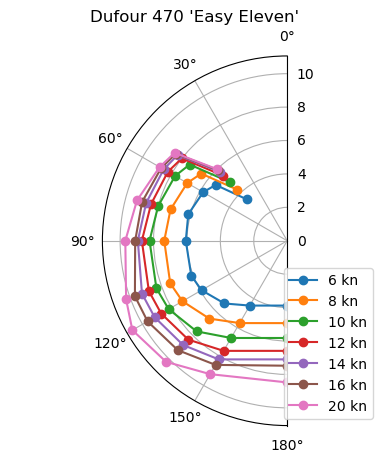

In [5]:
# Plot polar diagram of the boat
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_theta_zero_location("N")
ax.set_thetamin(0)
ax.set_thetamax(180)
for a, v in zip(angles, vel):
    ax.plot(np.deg2rad(a), v, "o-")
plt.legend([f"{ws} kn" for ws in boat["vpp"]["speeds"]], loc="lower right")
plt.title(boat["boat"]["type"] + " '" + boat["name"] + "'")
plt.show()

In [6]:
def velocity(course, wind_dir, wind_mag):
    angle = np.abs(((course + 360.0) % 360.0 - wind_dir))
    if angle > 180:
        angle = 360.0 - angle
    return lut((wind_mag, angle))

## Compute travel time 

In [7]:
def compute_path(waypoints, opt=True):
    # Build waypoints from start point, end point and optimization variables
    wpts = np.hstack([START, waypoints.reshape(2, -1), END])
    wpts = np.unique(wpts.round(decimals=6), axis=1)
    lons = wpts[0, :]
    lats = wpts[1, :]
    lengths = geoid.line_lengths(lons, lats)
    # Initialize integrated time
    int_time = 0
    # Initialize arrays to store path
    if not opt:
        t = []
        v = []
        la = []
        lo = []

    # Iterate over waypoint segments
    for i in range(1, len(lons)):
        # Integration steps along segment are 500m long, but at least 2 per path segment
        del_s = min(500, int(lengths[i - 1] / 3.0))
        flags = enums.GeodIntermediateFlag.AZIS_KEEP
        intp = geoid.inv_intermediate(
            lons[i - 1],
            lats[i - 1],
            lons[i],
            lats[i],
            del_s=del_s,
            terminus_idx=0,
            flags=flags,
        )
        ds = intp.del_s / NM

        # Iterate over integration points along segment
        for lon, lat, azi in zip(intp.lons, intp.lats, intp.azis):
            x, y = m(lon, lat)
            if m.is_land(x, y):
                # on land we penalize the solution with a very low speed
                vel = SLOW
            else:
                # at sea, we compute the speed from wind and polar diagram
                wind_dir, wind_mag = wind(int_time, lon, lat)
                vel = velocity(azi, wind_dir, wind_mag)
            # Integrate time
            int_time += ds / vel
            # Store path
            if not opt:
                t.append(int_time)
                v.append(vel)
                la.append(lat)
                lo.append(lon)
    if opt:
        return int_time
    else:
        return {
            "time": np.array(t),
            "velocity": np.array(v),
            "lons": np.array(lo),
            "lats": np.array(la),
        }

## Optimization

In [8]:
# Create initial population
POPSIZE = 15
N = 8
wp = geoid.npts(STA_LON, STA_LAT, END_LON, END_LAT, N)
waypoints = np.array([[pos[0] for pos in wp], [pos[1] for pos in wp]])
noise = 0.05 * (np.random.rand(POPSIZE, len(waypoints.ravel())) - 0.5)
initial_population = np.tile(waypoints.ravel(), (POPSIZE, 1)) + noise

bounds = N * [(MIN_LON, MAX_LON)] + N * [(MIN_LAT, MAX_LAT)]
opt = differential_evolution(compute_path, bounds, maxiter=100, init=initial_population)
waypoints = opt.x.reshape(2, -1)

path = compute_path(waypoints, opt=False)
full_waypoints = np.hstack([START, waypoints, END])
dist = geoid.line_length(full_waypoints[0, :], full_waypoints[1, :]) / NM

# Print resulting calculation
td = datetime.timedelta(hours=path["time"][-1])
td = ":".join(str(td).split(":")[:2])
print(f"The travel time is {td} h for {dist:.2f} nautical miles.")

The travel time is 4:09 h for 46.16 nautical miles.


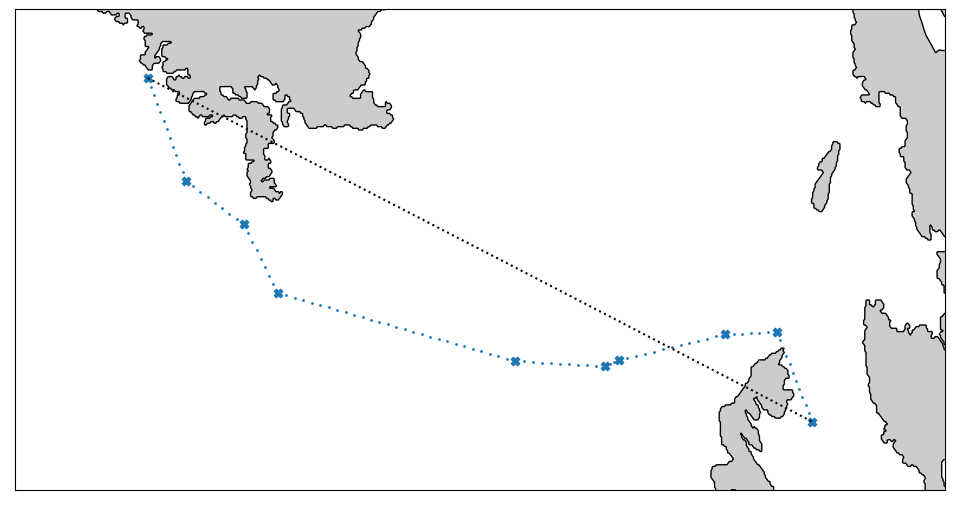

In [9]:
plt.figure(figsize=(12, 12))
m.drawcoastlines()
m.fillcontinents()
m.drawgreatcircle(STA_LON, STA_LAT, END_LON, END_LAT, del_s=1, color="k", linestyle=":")
x, y = m(path["lons"], path["lats"])
velocity = path["velocity"]
vmin = np.min(path["velocity"])
vmax = np.max(path["velocity"])
scat = m.scatter(x, y, color="tab:blue", s=1)
x, y = m(full_waypoints[0, :], full_waypoints[1, :])
m.scatter(x, y, color="tab:blue", marker="X")

# Draw plot
plt.draw()

## Plot path

In [10]:
def plot_func(time):
    # Clear plot
    plt.clf()

    # Draw map
    m.drawcoastlines()
    m.fillcontinents()
    m.drawgreatcircle(
        STA_LON,
        STA_LAT,
        END_LON,
        END_LAT,
        del_s=1,
        color="k",
        linestyle=":",
    )

    # Print wind magnitude
    wlons, wlats = np.meshgrid(wind_lons, wind_lats)
    xx, yy = m(wlons, wlats)
    wdir, wmag = wind(time, wlons, wlats)
    cont = m.contourf(xx, yy, wmag, cmap="magma", alpha=0.5)
    plt.colorbar(cont, label="Windspeed in kn")

    # Plot wind barbs
    all_lons = np.linspace(MIN_LON, MAX_LON, 8)
    all_lats = np.linspace(MIN_LAT, MAX_LAT, 8)
    alons, alats = np.meshgrid(all_lons, all_lats)
    xx, yy = m(alons, alats)
    wdir, wmag = wind(time, alons, alats)
    vx = -wmag * np.sin(np.deg2rad(wdir))
    vy = -wmag * np.cos(np.deg2rad(wdir))
    m.barbs(xx, yy, vx, vy)

    # Plot path
    idx = np.where(path["time"] < time)
    x, y = m(path["lons"][idx], path["lats"][idx])
    velocity = path["velocity"][idx]
    vmax = np.max(path["velocity"])
    scat = m.scatter(x, y, c=velocity, vmin=0.0, vmax=vmax)
    plt.colorbar(scat, label="Boatspeed in kn")

    # Plot waypoints
    x, y = m(full_waypoints[0, :], full_waypoints[1, :])
    m.scatter(x, y, color="k", marker="X")

    # Draw plot
    plt.draw()


widgets.interact(
    plot_func,
    time=widgets.FloatSlider(
        value=path["time"][-1], min=0.1, max=path["time"][-1], step=0.1
    ),
)

interactive(children=(FloatSlider(value=4.163091247320685, description='time', max=4.163091247320685, min=0.1)…

<function __main__.plot_func(time)>

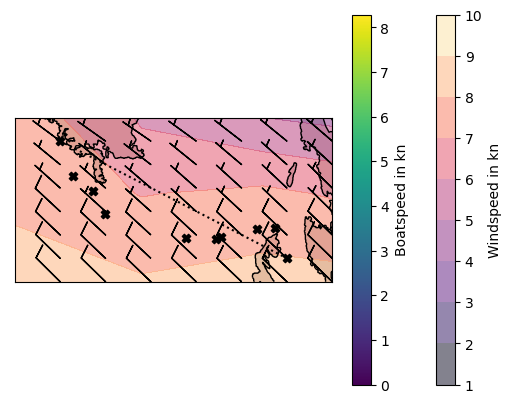

In [11]:
fig = plt.figure()
anim = animation.FuncAnimation(
    fig, func=plot_func, frames=np.linspace(0, path["time"][-1], 60)
)
anim.save("animation.gif")